In [60]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


### Partie 1 - Base de données, Analyse et Préparation
#### Chargement des images

In [61]:
files = "./Mask_Data"

data_dir = pathlib.Path(files)
data_dir

WindowsPath('Mask_Data')

In [62]:
image_count = len(list(data_dir.glob('*/*.*')))
image_count

1508

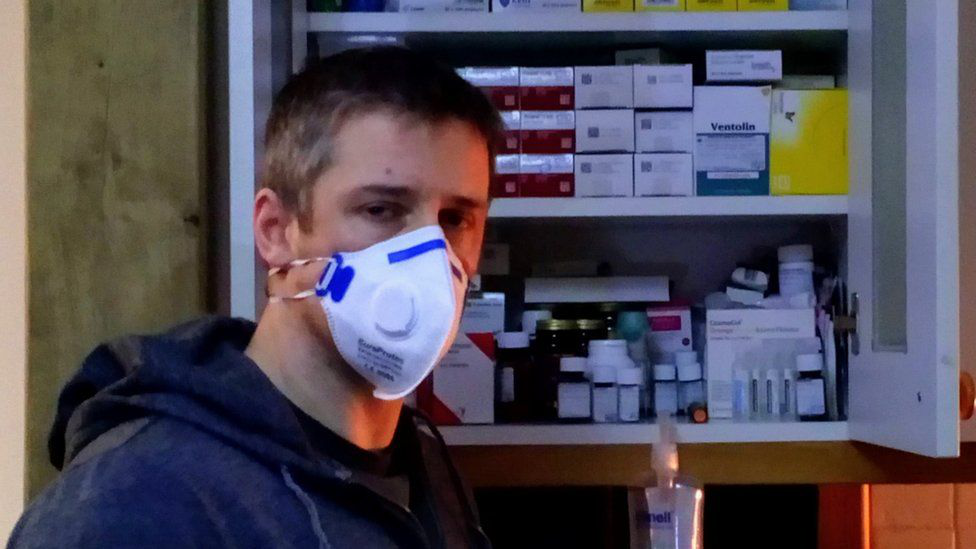

In [63]:
with_mask = list(data_dir.glob('with_mask/*'))
PIL.Image.open(str(with_mask[1]))

In [64]:
(with_mask[:5])

[WindowsPath('Mask_Data/with_mask/-110603108-gettyimages-533567012.jpg'),
 WindowsPath('Mask_Data/with_mask/-110695084-mask2.jpg'),
 WindowsPath('Mask_Data/with_mask/0-with-mask.jpg'),
 WindowsPath('Mask_Data/with_mask/0000305-62360-halyard-health-pfr-p3-respirator-face-mask-ffp.jpeg'),
 WindowsPath('Mask_Data/with_mask/0000444-48296-halyard-health-surgical-mask-teddy-bear-print.jpeg')]

In [17]:
IMG_SHAPE = (224, 224)

img = cv2.imread(str(with_mask[1]))
img.shape


(549, 976, 3)

In [65]:
cv2.resize(img, IMG_SHAPE).shape

(224, 224, 3)

In [66]:
mask_images_dict = {
    'with_mask' : list(data_dir.glob('with_mask/*')),
    'without_mask' : list(data_dir.glob('without_mask/*'))
}

In [67]:
mask_label_dict = {
    'with_mask' : 0,
    'without_mask' : 1
}

#### Redimensionner les images selon le modèle VGG16

In [68]:
X, y = [], []

for mask_label, images in mask_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, IMG_SHAPE)
        X.append(resized_img)
        y.append(mask_label_dict[mask_label])

#### Transformation des listes en np.array

In [69]:
X = np.array(X)
y = np.array(y)

#To categorical
y = tf.keras.utils.to_categorical(y, num_classes=2)


In [70]:
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

#### Splitter les données en données d’apprentissage et test.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [72]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

In [73]:
X_train_scaled.shape

(1206, 224, 224, 3)

In [74]:
X_test_scaled.shape

(302, 224, 224, 3)

#### Visualiser les images de la classe Avec_Masque et Sans_Masque

[0. 1.]


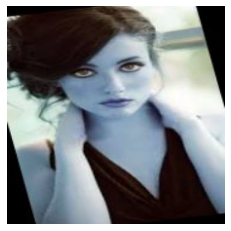

In [75]:
plt.axis('off')
plt.imshow(X_train_scaled[1])
print(y_train[1])

[1. 0.]


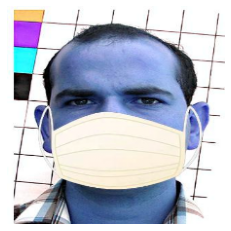

In [76]:
plt.axis('off')
plt.imshow(X_train_scaled[89])
print(y_train[89])

### Partie 2 : Architecture CNN sur Tensorflow

In [77]:
import keras
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16

In [78]:
model = VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Architecture VGG16

In [79]:
# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape = IMG_SHAPE+(3,)) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Ajout des 4 dernières couches - transformation de l'image en vecteur (flatten) et ajout des hidden layers (dense)

In [80]:
model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten()) 
model.add(Dense(4096,activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['acc'])



In [81]:
history = model.fit(X_train_scaled, y_train, epochs=5, validation_data = (X_test_scaled, y_test))

Epoch 1/5


C:\Users\utilisateur\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


38/38 [==============================] - 1130s 29s/step - loss: 1.7210 - acc: 0.8955 - val_loss: 0.0836 - val_acc: 0.9735
Epoch 2/5
38/38 [==============================] - 3439s 92s/step - loss: 0.0193 - acc: 0.9917 - val_loss: 0.1787 - val_acc: 0.9603
Epoch 3/5
38/38 [==============================] - 4839s 130s/step - loss: 0.0205 - acc: 0.9950 - val_loss: 0.2779 - val_acc: 0.9470
Epoch 4/5
38/38 [==============================] - 488s 13s/step - loss: 0.0267 - acc: 0.9950 - val_loss: 0.1387 - val_acc: 0.9702
Epoch 5/5
38/38 [==============================] - 473s 13s/step - loss: 0.0087 - acc: 0.9983 - val_loss: 0.2010 - val_acc: 0.9702


<ipython-input-52-d244700583d6>:3: MatplotlibDeprecationWarning: Unrecognized location 'lower_right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc = 'lower_right')


Text(0, 0.5, 'loss')

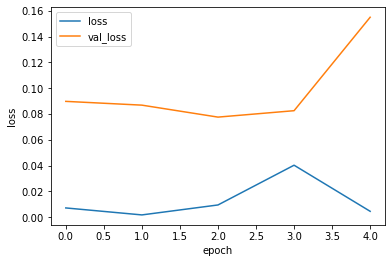

In [52]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'lower_right')
plt.xlabel('epoch')
plt.ylabel('loss')

10/10 - 173s - loss: 1.9702 - acc: 0.9834 - 173s/epoch - 17s/step


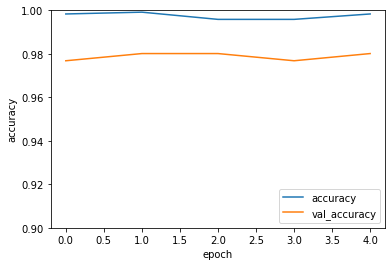

In [55]:
plt.plot(history.history['acc'], label = 'accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 2)